## Обучение на основе модели: алгоритм Dyna-Q

В данной тетрадке мы реализуем табличный алгоритм Dyna-Q. Для этого мы воспользуемся кодом для табличного Q-обучения.

<img src="https://raw.githubusercontent.com/Tviskaron/mipt/master/2019/RL/10/dyna.png">

In [ ]:
try:
    import google.colab
    COLAB = True
except ModuleNotFoundError:
    COLAB = False
    pass

if COLAB:
    !pip -q install "gymnasium[classic-control, atari, accept-rom-license]"
    !pip -q install piglet
    !pip -q install imageio_ffmpeg
    !pip -q install moviepy==1.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 12.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.5/67.5 kB 8.5 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
from functools import partial
from IPython.display import clear_output

%matplotlib inline

In [ ]:
def show_progress(rewards_batch, log, reward_range=None):
    """
    Удобная функция, которая отображает прогресс обучения.
    """

    if reward_range is None:
        reward_range = [-990, +10]
    mean_reward = np.mean(rewards_batch)
    log.append([mean_reward])

    clear_output(True)
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.legend(loc=4)
    plt.grid()
    plt.grid()
    plt.show()

def compare_logs(logs):
    """Функция сравнения кривых обучения"""
    for log, method_name in logs:
        plt.plot(log, label=f'{method_name}')
        plt.legend()
    plt.show()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


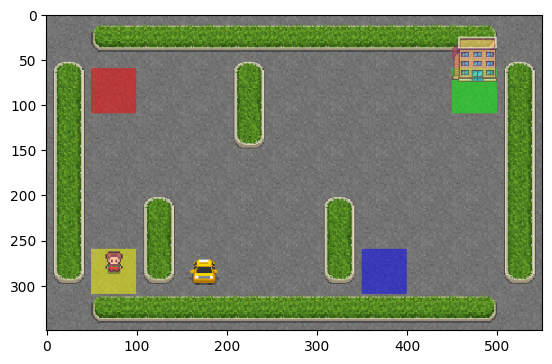

In [ ]:
env = gym.make("Taxi-v3", render_mode="rgb_array")
env.reset(seed=13)
plt.imshow(env.render())

### Задание 1: Реализуйте методы класса Model, которые позволят вам сохранять и получать необходимые кортежи данных.

In [ ]:
import random
class Model:
    def __init__(self, n_states, n_actions, seed):
        ####### Здесь ваш код ########
        self.n_states = n_states
        self.n_actions = n_actions
        self._transitions = np.zeros((n_states, n_actions), dtype=np.int32)
        self._rewards = np.zeros_like(self._transitions, dtype=np.float32)
        self.visited = set()
        ##############################
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        ####### Здесь ваш код ########
        self._rewards[s, a] = r
        self._transitions[s, a] = next_s
        self.visited.add((s, a))
        ##############################
        return r

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        ####### Здесь ваш код ########
        s, a = random.sample(self.visited, 1)[0]
        r = self._rewards[s, a]
        next_s = self._transitions[s, a]
        return s, a, r, next_s 
        ##############################

In [ ]:
class DynaQAgent:
    def __init__(self, n_states, n_actions, lr, gamma, eps, f_model, seed):
        self.Q = np.zeros((n_states, n_actions))
        self.model = f_model(n_states, n_actions, seed=seed)
        self.lr = lr
        self.gamma = gamma
        self.eps = eps
        self.n_actions = n_actions
        self._rng = np.random.default_rng(seed)
        
    def act(self, s):
        # выбираем действие, используя eps-greedy исследование среды
        # с вероятностью epsilon выбираем случайное действие, иначе
        # выполняем действие жадно, согласно текущей Q-таблице
        if self._rng.random() < self.eps:
            action = self._rng.choice(self.n_actions)
        else:
            action = np.argmax(self.Q[s])  # используем Q-функцию
        return action

    def update(self, s, a, r, s_n, update_model: bool):
        # Обновите модель, если нужно, реализуйте шаг Q-обучения
        ####### Здесь ваш код ########
        self.Q[s, a] += self.lr * (r + self.gamma * np.max(self.Q[s_n]) - self.Q[s, a])
        if update_model:
            _ = self.model.add(s, a, r, s_n)
        ##############################
        
    def dream(self, max_steps):
        for _ in range(max_steps):
            # Добавьте шаг обучения с использованием модели
            ####### Здесь ваш код ########
            s, a, r, s_n = self.model.sample()
            self.update(s, a, r, s_n, False)
            ##############################

In [ ]:
def train(env, agent, episodes_number, on_model_updates, seed):
    log, rewards_batch = [], []
    rng = np.random.default_rng(seed)

    for i in range(1, episodes_number):
        state, _ = env.reset(seed=int(rng.integers(10000000)))

        episode, reward, episode_reward = 0, 0, 0
        done = False

        while not done:
            action = agent.act(state)

            # выполняем действие в среде
            next_state, reward, terminated, truncated, info = env.step(action)
            agent.update(state, action, reward, next_state, update_model=True)
            agent.dream(on_model_updates)

            state = next_state
            episode += 1
            episode_reward += reward
            done = terminated or truncated

        rewards_batch.append(episode_reward)

        if i % 50 == 0:
            show_progress(rewards_batch, log)
            rewards_batch = []
            avg_rew = sum(r[0] for r in log) / (i / 50)
            print(f"Episode: {i}, Reward: {episode_reward}, Avg: {avg_rew:.0f}")
    return log

### Обычный Q-learning

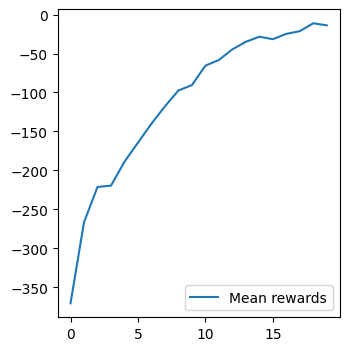

Episode: 1000, Reward: -5, Avg: -111


In [ ]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1, gamma=0.95, eps=0.1, seed=seed,
    f_model=Model
)

log_q = train(env, agent, episodes_number=1001, on_model_updates=0, seed=seed)

### DynaQ

1. Сравните скорость обучения алгоритма Dyna-Q с параметром on_model_updates равным 7 и алгоритма Q-обучение.
2. Сравните скорость обучения при различных on_model_updates. В каком случае получились лучшие результаты?

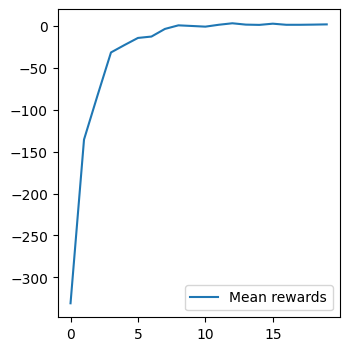

Episode: 1000, Reward: -9, Avg: -31


In [ ]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1, gamma=0.95, eps=0.1, seed=seed,
    f_model=Model
)
log_dyna_q = train(env, agent, episodes_number=1001, on_model_updates=7, seed=seed)

In [ ]:
class ImperfectModel:
    def __init__(self, n_states, n_actions, lr: float, seed: int):
        ####### Здесь ваш код ########
        self.n_states = n_states
        self.n_actions = n_actions
        self._transitions = np.zeros((n_states, n_actions), dtype=np.int32)
        self._rewards = np.zeros_like(self._transitions, dtype=np.float32)
        self.mask_state_action =  np.ma.zeros_like(self._transitions, dtype=np.float32)
        self.mask_state = np.ma.zeros(n_states, dtype=np.int32)
        self.lr = lr
        
        self.c = 7
        ##############################
        self._rng = np.random.default_rng(seed)

    def add(self, s: int, a: int, r: float, next_s: int) -> float:
        ####### Здесь ваш код ########
        self._rewards[s, a] = r
        self._transitions[s, a] = next_s
        self.mask_state[s] += 1
        self.mask_state_action[s, a] = min(self.mask_state_action[s, a]+self.lr, 1) 

        #converting counters to probs -> renormalisation
        # for idx in range(self.n_states):
        #     if self.mask_state[idx] == 0:
        #         self.mask_state_action[idx, :] = 1./ self.n_actions
        #     else:
        #         self.mask_state_action[idx, :] /= self.mask_state[idx]
        ##############################
        return r 

    def sample_state(self):
        ####### Здесь ваш код ########
        s = self._rng.choice(self.mask_state.nonzero())[0]
        ##############################
        return s

    def sample_action(self, s):
        ####### Здесь ваш код ########
        a = np.argmax(self.mask_state_action[s] + self.c * np.sqrt(self.mask_state_action[s]))
        ##############################
        return a

    def predict_transition(self, s, a):
        anomaly_prob = 1 - self.mask_state_action[s, a]
        if self._rng.random() < anomaly_prob:
            next_s = self._rng.choice(self.mask_state.size)
        else:
            next_s = self._transitions[s, a]
            
        self._dreaming_state = next_s
        return self._rewards[s, a], next_s

    def sample(self) -> tuple[int, int, float, int]:
        """
        returns s, a, r, next_s
        """
        ####### Здесь ваш код ########
        s = self.sample_state()
        a = self.sample_action(s)
        r, next_s = self.predict_transition(s, a)
        return s, a, r, next_s 
        ##############################

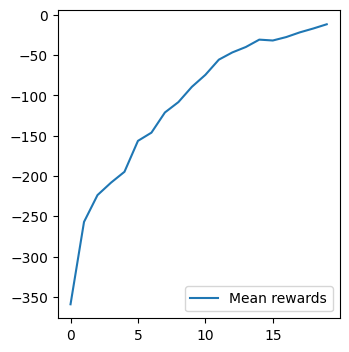

Episode: 1000, Reward: -5, Avg: -111


In [ ]:
env = gym.make("Taxi-v3")
seed = 1337
agent = DynaQAgent(
    env.observation_space.n, env.action_space.n, lr=0.1, gamma=0.95, eps=0.1, seed=seed,
    f_model=partial(ImperfectModel, lr=0.3)
)

log_dyna_q_imp = train(env, agent, episodes_number=1001, on_model_updates=7, seed=seed)

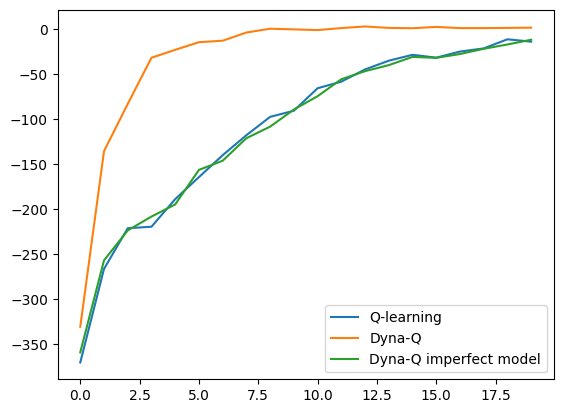

In [ ]:
compare_logs([
    (log_q, 'Q-learning'),
    (log_dyna_q, 'Dyna-Q'),
    (log_dyna_q_imp, 'Dyna-Q imperfect model'),
])